In [1]:
import torchvision.models
alexNet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\Maxwell/.cache\torch\checkpoints\alexnet-owt-4df8aa71.pth


In [2]:
alexNet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [3]:
alexNet.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [4]:
alexNet.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

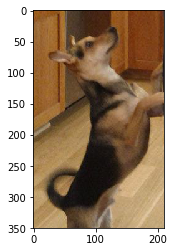

In [6]:
import matplotlib.pyplot as plt
import numpy as np

img = plt.imread('https://drive.google.com/uc?export=view&id=1oaLVR2hr1_qzpKQ47i9rVUIklwbDcews')

img = img[:,:,:3]
plt.imshow(img)

In [8]:
import torch

x = torch.from_numpy(img)
print(x.shape)

x = x.permute(2, 0, 1)
print(x.shape)

torch.Size([350, 210, 3])
torch.Size([3, 350, 210])


In [9]:
x = x.reshape([1, 3, 350, 210])
print(x.shape)

torch.Size([1, 3, 350, 210])


In [11]:
features = alexNet.features(x)
features.shape

torch.Size([1, 256, 9, 5])

In [12]:
alexNetConv = alexNet.features[0]
y = alexNetConv(x)
y.shape

torch.Size([1, 64, 86, 51])

In [13]:
y = y.detach().numpy()
y = (y-y.min()) / (y.max()-y.min())
y.shape

(1, 64, 86, 51)

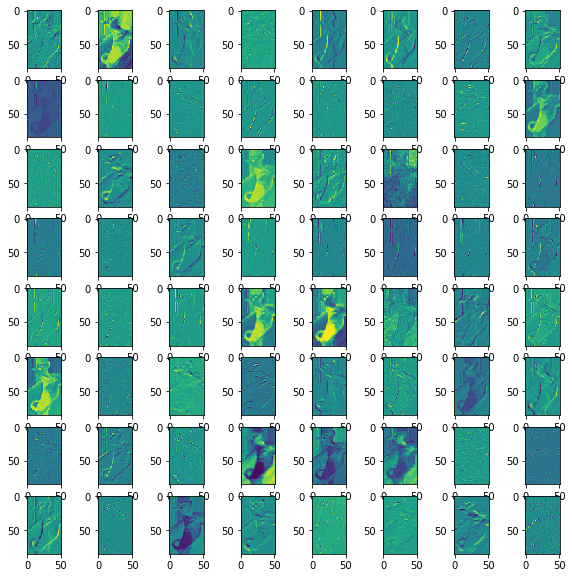

In [14]:
plt.figure(figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(y[0, i])

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [21]:
torch.manual_seed(1)

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)
mnist_train = mnist_data[:20]
mnist_val = mnist_data[100:5100]

In [23]:
class MNISTClassifier(nn.Module):
    
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.layer1 = nn.Linear(28*28, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 10)
        
    def forward(self, img):
        flattened = img.view(-1, 28*28)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        return self.layer3(activation2)

In [25]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval() #*********#
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [32]:
def train(model, train, valid, batch_size=20, num_iters=1, learn_rate=0.01, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9, weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    while True:
        if n >= num_iters:
            break
        for imgs, labels in iter(train_loader):
            model.train() #*****************************#
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            if n % 10 == 9:
                iters.append(n)
                losses.append(float(loss)/batch_size)        # compute *average* loss
                train_acc.append(get_accuracy(model, train)) # compute training accuracy 
                val_acc.append(get_accuracy(model, valid))   # compute validation accuracy
            n += 1

    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [30]:
train_acc_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100)
val_acc_loader = torch.utils.data.DataLoader(mnist_val, batch_size=1000)

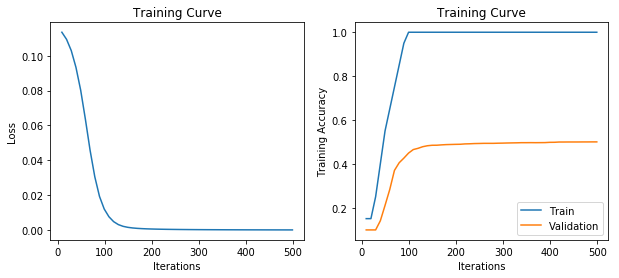

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5


In [33]:
model = MNISTClassifier()
train(model, mnist_train, mnist_val, num_iters=500)

In [35]:
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

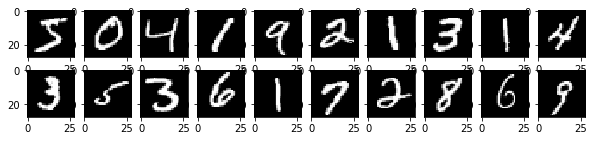

In [36]:
def show20(data):
    plt.figure(figsize=(10, 2))
    for n, (img, label) in enumerate(data):
        if n >= 20:
            break
        plt.subplot(2, 10, n+1)
        plt.imshow(img)
        
mnist_imgs = datasets.MNIST('data', train=True, download=True)
show20(mnist_imgs)

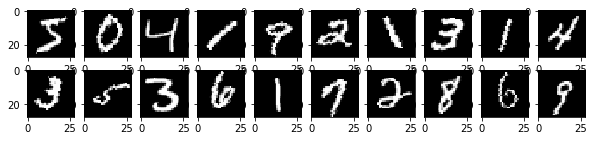

In [37]:
mnist_new = datasets.MNIST('data', train=True, download=True, transform=transforms.RandomRotation(25))
show20(mnist_new)

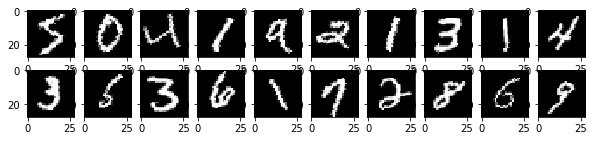

In [38]:
mnist_new = datasets.MNIST('data', train=True, download=True, transform=transforms.RandomRotation(25))
show20(mnist_new)

In [43]:
augmented_train_data = []

my_transform = transforms.Compose([transforms.RandomRotation(25), transforms.ToTensor(),])

for i in range(100):
    mnist_new = datasets.MNIST('data', train=True, download=True, transform=my_transform)
    for j, item in enumerate(mnist_new):
        if j >= 20:
            break
        augmented_train_data.append(item)
        
len(augmented_train_data)

2000

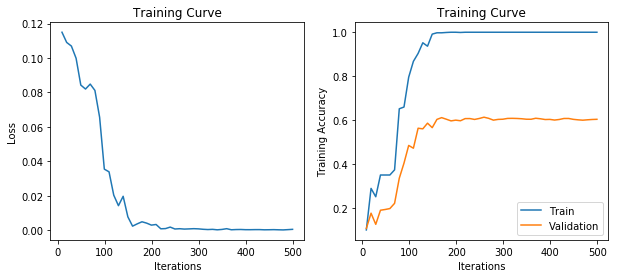

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6036


In [44]:
model = MNISTClassifier()
train(model, augmented_train_data, mnist_val, num_iters=500)

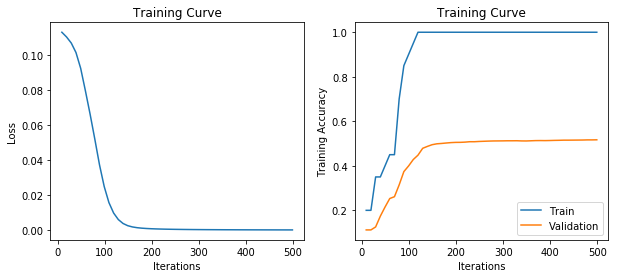

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5168


In [45]:
model = MNISTClassifier()
train(model, mnist_train, mnist_val, num_iters=500, weight_decay=0.001)

In [46]:
class MNISTClassifierWithDropout(nn.Module):
    
    def __init__(self):
        super(MNISTClassifierWithDropout, self).__init__()
        self.layer1 = nn.Linear(28*28, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 10)
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.4)
        self.dropout3 = nn.Dropout(0.4)
        
    def forward(self, img):
        flattened = img.view(-1, 28*28)
        activation1 = F.relu(self.layer1(self.dropout1(flattened)))
        activation2 = F.relu(self.layer2(self.dropout2(activation1)))
        return self.layer3(self.dropout3(activation2))

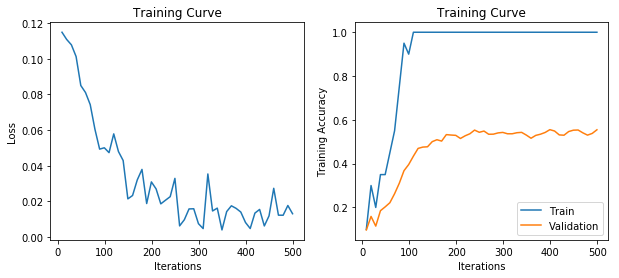

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5546


In [47]:
model = MNISTClassifierWithDropout()
train(model, mnist_train, mnist_val, num_iters=500)